In [1]:
#Initialize
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

#Paths & names
image_path = "C:\\Users\\JH\\Dropbox\\ForcastChallenge\\sampleImgs\\"
act_dataset_path = "C:\\Datasets\\ActivityDataset\\"

#Region of interest
roiX = 140
roiY = 280
roiW = 1120
roiH = 600

def getROI(img):
    return img[(-roiY-roiH):(-roiY),roiX:(roiX+roiW)]

def myimread(path):
    img_bgr = cv2.imread(path)
    roi_bgr = getROI(img_bgr)
    return cv2.cvtColor(roi_bgr,cv2.COLOR_BGR2RGB)

#'Background' image
bgm_img_name = "snap_2018-04-17_12_07_01.jpeg"
bg_img = myimread(image_path + bgm_img_name)

#Test image
test_img_name = "snap_2018-04-17_13_23_53.jpeg"

#Get Forcast paths
a = list(os.walk(image_path)) #lista de 1 tuple
_,_,file_names = a[0] #tuple de 3, con <ruta_carpeta>, lista de <nombre_carpeta_hija>, lista de <archivos_en_carpeta>


#Get Collective Activity Dataset paths
b = list(os.walk(act_dataset_path)) #lista de 45 tuples, 1 por cada carpeta en el path
useful_folders = [10,11,12,13,14,25,26,28,29,30,33,34,36,37,38,39,40,41,42,43]

In [3]:
#parse annotations
def parseAnnotations(walked_tuple):
    from copy import deepcopy
    folder_path,_,image_names = deepcopy(walked_tuple)
    image_names.pop(0)
    annotations = open(folder_path + '\\annotations.txt','r')
    bb_array_list = []
    current_image = 0
    current_index = -1
    
    for line in annotations:
        aux1 = line.rstrip()
        aux2 = aux1.split()
        aux3 = np.array(aux2)
        aux4 = aux3.astype(int)
        aux5 = aux4.reshape(1,7)
        this_image = aux5[0][0]
        if this_image == current_image:
            bb_array_list[current_index] = np.append(bb_array_list[current_index],aux5,axis=0)
        else:
            current_image = this_image
            current_index += 1
            bb_array_list.append(aux5)

    annotations.close()
    return bb_array_list

In [4]:
def getCOADrois(folder_number, image_number = 1):
#Get SIFT from ROIs of some COllective Activity Dataset image
#Check if image_number has annotations first

    image_name = b[folder_number][2][image_number]
    image_path = b[folder_number][0] + "\\" + image_name
    #Get info from the annotations
    bba = parseAnnotations(b[folder_number])
    #Open COAD image
    img_bgr = cv2.imread(image_path)
    img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)

    #Compute SIFT keypoints for each roi in the image
    rois = []
    #Find image index in bba
    for idx,elem in enumerate(bba):
        if elem[0][0] == image_number:
            break
    for roiline in bba[idx]:
        rois.append(img[roiline[2]:(roiline[2]+roiline[4]),roiline[1]:(roiline[1]+roiline[3])])
        
    return img,rois

In [5]:
def getListOfSIFT(rois,nFeatures):
    sift = cv2.xfeatures2d.SIFT_create(nFeatures)
    kp_list = []
    desc_list = []
    for idx,im in enumerate(rois):
        kp,desc = sift.detectAndCompute(im,None)
        kp_list.append(kp)
        desc_list.append(desc)
    return kp_list,desc_list

def getDescriptorArrayOfSIFT(rois,nFeatures):
    sift = cv2.xfeatures2d.SIFT_create(nFeatures)
    kp_list = None
    desc_list = None
    for idx,im in enumerate(rois):
        kp,desc = sift.detectAndCompute(im,None)
        if kp_list == None:
            kp_list = kp
            desc_list = desc
        else:
            np.append(kp_list,kp)
            np.append(desc_list,desc)
    return kp_list,desc_list
        
def plotKPs(rois,kp_list):
    kp_images = []
    for idx,im in enumerate(rois): 
        kp_im = im.copy()
        gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
        cv2.drawKeypoints(gray,kp_list[idx],kp_im)
    
        plt.subplot(1,len(rois),idx+1)
        plt.imshow(kp_im)
        kp_images.append(kp_im)
    plt.subplots_adjust(0,0,2,2,0.1,0)
    return kp_images

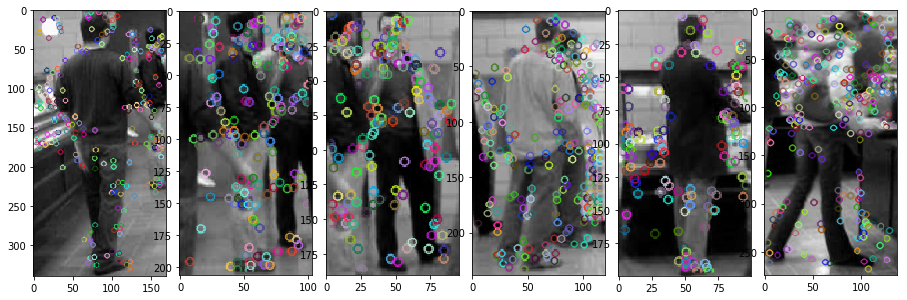

In [6]:
img,rois = getCOADrois(useful_folders[0])
kp_list,desc_list = getListOfSIFT(rois,0)
kp_images = plotKPs(rois,kp_list)

for idx,roi in enumerate(rois):
    cv2.imwrite("C:\\Users\\JH\\Desktop\\roi" + str(idx) +".png",cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))
    cv2.imwrite("C:\\Users\\JH\\Desktop\\kp" + str(idx) +".png",kp_images[idx])

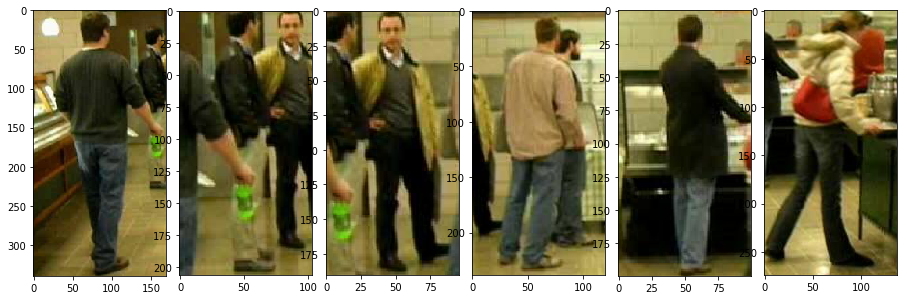

In [7]:
for idx,im in enumerate(rois):
    plt.subplot(1,len(rois),idx+1)
    plt.imshow(rois[idx])
plt.subplots_adjust(0,0,2,2,0.1,0)

In [8]:
#Generate kp images for visualization
for id1,fd in enumerate(useful_folders):
    img,rois = getCOADrois(fd)
    kp_list,desc_list = getListOfSIFT(rois,0)
    for id2,im in enumerate(rois):
        kp_im = im.copy()
        gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
        cv2.drawKeypoints(gray,kp_list[id2],kp_im)
        cv2.imwrite("C:\\Users\\JH\\Desktop\\kps\\kp_im_" + str(fd) + "_" + str(id2) + ".jpg",kp_im)

In [9]:
#Generate kp descriptor for database
desc_db = None
for id1,fd in enumerate(useful_folders):
    img,rois = getCOADrois(fd)
    kp_list,desc_list = getDescriptorArrayOfSIFT(rois,0)
    if not isinstance(desc_db, np.ndarray):
        desc_db = desc_list
    else:
        desc_db = np.append(desc_db,desc_list,0)

In [10]:
desc_db.shape

(3867, 128)

In [11]:
#Save descriptor database to file
fid = open("C:\\Users\\JH\\Desktop\\kps\\desc_db.txt","w")
desc_db.tofile(fid,"\t")
fid.close()

# Aplicar FD a ForcastDS y buscar matches con DescDB

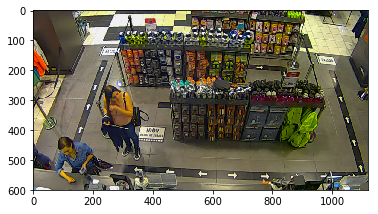

In [12]:
#Get test image
test_img = myimread(image_path + test_img_name)
plt.imshow(test_img)

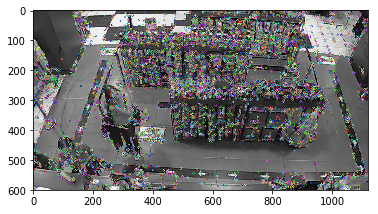

In [13]:
#Get descriptors for FC image
sift = cv2.xfeatures2d.SIFT_create(0)
kp,desc = sift.detectAndCompute(test_img,None)

test_img_copy = test_img.copy()
gray = cv2.cvtColor(test_img_copy,cv2.COLOR_RGB2GRAY)
cv2.drawKeypoints(gray,kp,test_img_copy)

plt.imshow(test_img_copy)

In [14]:
#Get matching descriptors
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

# Match descriptors.
matches = bf.match(desc,desc_db)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [15]:
matches

[<DMatch 000000000A0BC970>,
 <DMatch 000000000A0F74D0>,
 <DMatch 000000000A0895D0>,
 <DMatch 000000000A0F74F0>,
 <DMatch 0000000009093E10>,
 <DMatch 0000000009093B30>,
 <DMatch 000000000A0A09B0>,
 <DMatch 000000000A0BC930>,
 <DMatch 0000000009093A30>,
 <DMatch 000000000A0EDEB0>,
 <DMatch 000000000A0F77F0>,
 <DMatch 000000000A05DD70>,
 <DMatch 000000000A0413F0>,
 <DMatch 000000000A0CB990>,
 <DMatch 000000000A0CBEF0>,
 <DMatch 00000000097A7310>,
 <DMatch 00000000097A7210>,
 <DMatch 0000000009786870>,
 <DMatch 00000000097811F0>,
 <DMatch 000000000A089890>,
 <DMatch 00000000097EDC30>,
 <DMatch 0000000009093490>,
 <DMatch 000000000A0DD930>,
 <DMatch 0000000009786150>,
 <DMatch 000000000A0BA9D0>,
 <DMatch 0000000009781EF0>,
 <DMatch 0000000009786E10>,
 <DMatch 000000000A04BED0>,
 <DMatch 000000000A3104B0>,
 <DMatch 00000000097E34F0>,
 <DMatch 000000000A041E30>,
 <DMatch 000000000A041670>,
 <DMatch 00000000097E3330>,
 <DMatch 000000000A04B310>,
 <DMatch 000000000A0BC1B0>,
 <DMatch 00000000097